In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl 
from scipy import stats

%matplotlib inline
mpl.rcParams['patch.force_edgecolor'] = True
sns.set()

Import dataframe (generated in `data_wrangling` notebook) containing NYT and Yelp data.

In [197]:
df_nyt_yelp = pd.read_pickle('import/df_nyt_yelp.pkl')
df_nyt_yelp.head()

,nyt_name,nyt_review_time,yelp_id,isclosed,yelp_rating,reviewcount,yelp_price,yelp_url,yelp_name,critics_pick,nyt_stars,yelp_reviews
0,Davelle,"June 7, 2018",PwrYnl3j3YCGzILX_5UHpw,False,4.0,47.0,2,https://www.yelp.com/biz/davelle-new-york-2,Davelle,y,NaN,NaN
1,Lahi,"May 31, 2018",kDqW1eeZEDTitXerwzwCzw,False,4.5,4.0,1,https://www.yelp.com/biz/lahi-queens,LAHI,n,NaN,NaN
2,Don Angie,"May 29, 2018",h37t9rA06Sr4EetJjKrfzw,False,4.5,126.0,3,https://www.yelp.com/biz/don-angie-new-york,Don Angie,y,4.0,NaN
3,Rangoon Spoon,"May 24, 2018",chdmH_y3YReZgIlNzj8djQ,False,3.5,55.0,2,https://www.yelp.com/biz/rangoon-spoon-brooklyn,Rangoon Spoon,n,NaN,NaN
4,Wokuni,"May 22, 2018",D6ZEcG1FCZ18nekMWrhgMg,False,4.0,60.0,3,https://www.yelp.com/biz/wokuni-new-york,Wokuni,n,3.0,NaN


# 1. Yelp vs. NYT ratings

Our database consists of 563 restaurants that had a NYT and Yelp reviews beginning from 2012 through 2018 (current year). After data wrangling, each restaurant has both Yelp and NYT review data. The two review systems are actually quite different - another reason to visualize their ratings.

### 1.1 Discussion of Yelp & NYT: two different review systems

<b><u>1. Yelp review system</b></u>: Yelp's rating system operates from 1-5, lowest to highest. A restaurant's average rating is taken simply to be the average of all Yelp users' individual review ratings (i.e. no extra weight put on whether a Yelper is "Elite", etc.). This is the official documentation for what each rating means:
    - 1 = "Eek! Methinks not."
    - 2 = "Meh. I've experienced better."
    - 3 = "A-OK."
    - 4 = "Yay! I'm a fan."
    - 5 = "Woohoo! As good as it gets!"
   However, the user is free to interpret Yelp's rating system as they'd like and therefore is subjected to less control for bias/variance (both between users and within), compared to a news platform such as NYT that employs full-time critics and relies on the perception of consistency. Several interesting phenomena occur as a result, such as "a Yelp 4.0 being the average": https://venturebeat.com/2009/10/12/how-yelp-deals-with-everybody-getting-four-stars-on-average/ 

<b><u>2. NYT review system</b></u>: NYT's review system for restaurants is actually two-fold and consists of two sub-ratings:<p>
   <i><b>A. Stars</b></i>: A 1-4 rating system, where only the chief restaurant critic (Pete Wells) can assign star ratings. 
    - Poor
    - Fair
    - Satisfactory
    - 1 = Good 
    - 2 = Very Good
    - 3 = Excellent
    - 4 = Extraordinary
    
The star system may be somewhat counterintuitive, as any star (even 1) indicates approval from the chief critic and is consisted of merit. As a result, there are 3 additional ratings that precede stars in this system (in order from least to most approval): "Poor", "Fair", or "Satisfactory".
<p>
<b><i>B. “NYT Critic’s Pick”</b></i> - a seal of approval by any other NYT critic. This rating is binary - either a restaurant receives “NYT Critic’s Pick” or does not receive it, and no numeric scale is given for comparison between each instance of "NYT Critic's Pick".
    

<b>Conclusion</b>: As a result, we'll need to calibrate what consists of a "good"/"bad" rating label between Yelp and NYT when doing classification analyses later on.

### 1.2 Yelp & NYT rating distributions

To get a better idea of what constitutes relatively "good"/"bad" ratings within and between NYT and Yelp, we first take a look at their rating distributions. Similarly, we also examine the "NYT Critic's Pick" label to determine how it is assigned.

Number of restaurants w/ Yelp ratings:  563
Number of restaurants w/ NYT stars:  243


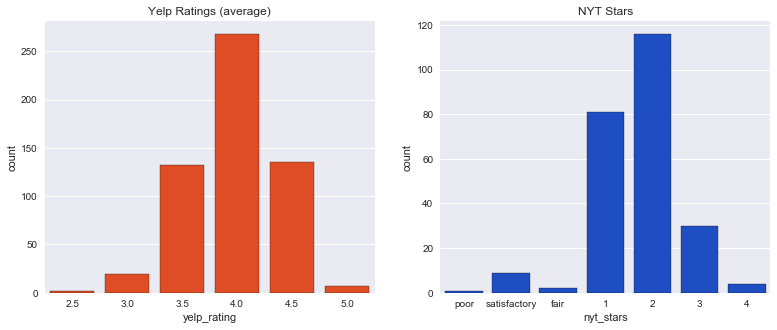

In [46]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

# Yelp plot
sns.countplot(x='yelp_rating', data=df_nyt_yelp, color=sns.xkcd_rgb['red orange'], ax=ax1).set_title('Yelp Ratings (average)');

# NYT plot
sns.countplot(x='nyt_stars', data=df_nyt_yelp, color=sns.xkcd_rgb['blue'], ax=ax2, 
              order = ['poor', 'satisfactory', 'fair','1','2','3','4']).set_title('NYT Stars');

print('Number of restaurants w/ Yelp ratings: ', len(df_nyt_yelp) - sum(df_nyt_yelp['yelp_rating'].isnull()))
print('Number of restaurants w/ NYT stars: ', len(df_nyt_yelp) - sum(df_nyt_yelp['nyt_stars'].isnull()))

<i>Yelp ratings</i>: 
- There's a fairly normal distribution to the ratings, a good sign for avoiding a skewed dataset that would indicate bias in how Yelp users review restaurants overall. 
- This distribution is also useful to visualize, as we'll need to determine a range of Yelp ratings corresponding to "good"/"bad" Yelp ratings for classification analysis.

<i>NYT stars</i>: 
- The number of restaurants w/ NYT stars is expected be to much lower, since stars can only be awarded by NYT's chief restaurant critic. 
- Because any star awarded by the NYT conveys prestige Thus, the NYT review system consists of two parts 1) stars, 2) whether it was a "NYT Critic's Pick" (an accolade awarded by any critic at NYT).

### 1.3 NYT stars vs. Yelp stars

We'd like to see if there's a relationship between Yelp and NYT stars. Our hypothesis is that average Yelp ratings will generally align with NYT ratings, with less variability at the extremes ("Poor"/"Fair" or 3-4 NYT stars).

To generate our plot, we take as each data point the Yelp and NYT stars for a restaurant with both. 

# restaurants w/ "Poor" (NYT):  1
# restaurants w/ "Fair" (NYT):  2
# restaurants w/ "Satisfactory" (NYT):  10
# restaurants w/ 1 star (NYT):  86
# restaurants w/ 2 star (NYT):  122
# restaurants w/ 3 star (NYT):  31
# restaurants w/ 4 star (NYT):  4


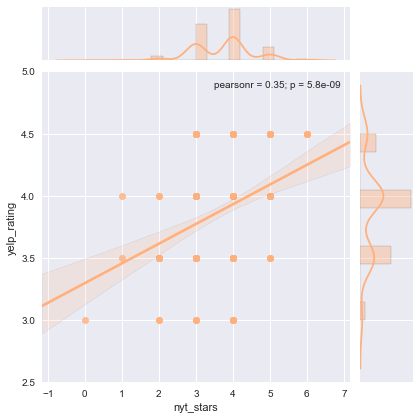

In [199]:
idx = pd.isnull(df_nyt_yelp['nyt_stars'])
df = df_nyt_yelp.drop(df_nyt_yelp[idx].index.tolist())

sns.jointplot(x='nyt_stars', y='yelp_rating', data=df, color=sns.xkcd_rgb['peach'], kind='reg');
print('# restaurants w/ "Poor" (NYT): ', sum(df['nyt_stars']==0))
print('# restaurants w/ "Fair" (NYT): ', sum(df['nyt_stars']==1))
print('# restaurants w/ "Satisfactory" (NYT): ', sum(df['nyt_stars']==2))
print('# restaurants w/ 1 star (NYT): ', sum(df['nyt_stars']==3))
print('# restaurants w/ 2 star (NYT): ', sum(df['nyt_stars']==4))
print('# restaurants w/ 3 star (NYT): ', sum(df['nyt_stars']==5))
print('# restaurants w/ 4 star (NYT): ', sum(df['nyt_stars']==6))

Recall that with NYT star rating system, at least 1 star awarded is already deemed as a positive review by a prestigious food critic. Since we have converted the stars to accomodate string-ratings such as "Poor" (0), "Fair" (1), and "Satisfactory" (2), our actual stars begin with nyt_stars = 3 in the figure above (which would be 1 star).

- <b>"Poor" & "Fair"</b>: There is a very small sample size (1 "Poor", 2 "Fair"). However they both correspond to at least 1 restaurant  w/ a poor Yelp rating (3.5 or 3.0). 
- <b>"Satisfactory"</b>: The range widens, but there are no restaurants above a 4.0 Yelp average.
- <b>1-2 NYT stars</b>: With the onset of NYT stars, the range widens to include 4.5 Yelp averages. 
- <b>3 NYT stars</b>: There are no longer any restaurants w/ Yelp averages < 3.5.
- <b>4 NYT stars</b>: No restaurant drops below a 4.5 Yelp average.

Our results support our hypothesis that Yelp average ratings generally align with NYT evaluations. It's particularly notable that restaurants w/ 4 NYT stars never has an average Yelp rating below 4.5 - restaurants at the highest tier of critical acclaim likely have strong Yelp ratings. 

### 1.4 NYT "Critic's Pick" vs. Yelp stars

In the previous section, we examined NYT's star rating system vs. Yelp stars. Now we compare NYT's "Critic's Pick" label to Yelp stars.

Average Yelp rating (received NYT Critics Pick):  4.0
Average Yelp rating (didnt receive NYT Critics Pick):  3.918181818181818


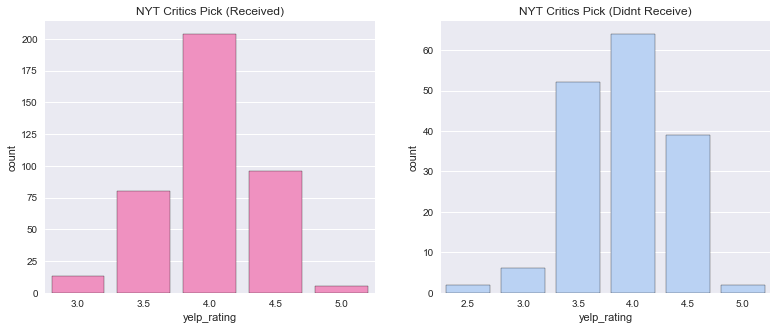

In [213]:
df1 = df_nyt_yelp[df_nyt_yelp['critics_pick']=='y']
df2 = df_nyt_yelp[df_nyt_yelp['critics_pick']=='n']

y1 = df1['yelp_rating']
y2 = df2['yelp_rating']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

sns.countplot(y1, color=sns.xkcd_rgb['pink'], ax=ax1).set_title('NYT Critics Pick (Received)');
sns.countplot(y2, color=sns.xkcd_rgb['powder blue'], ax=ax2).set_title('NYT Critics Pick (Didnt Receive)');

print('Average Yelp rating (received NYT Critics Pick): ', y1.mean())
print('Average Yelp rating (didnt receive NYT Critics Pick): ', y2.mean())

There's a lot more variability/unpredictability in whether a "NYT Critic's Pick" award indicates a higher Yelp rating. In fact, the difference between average Yelp rating between "received" and "didn't receive" seems insignificant. Therefore, it probably isn't useful to use "NYT Critic's Pick" as a predictor of Yelp rating.

# 2. Yelp - some general data visualizations

### 2.1 Number of reviews written for each restaurant

Visualizing how many Yelp reviews have been written for each restaurant.

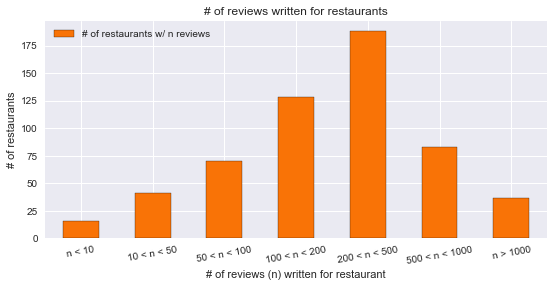

In [73]:
# Generating categories of restaurants by how many Yelp reviews they have

num_review_10 = sum(num <= 10 for num in df_nyt_yelp['reviewcount'])
num_review_50 = sum(num <= 50 and num > 10 for num in df_nyt_yelp['reviewcount'])
num_review_100 = sum(num <= 100 and num > 50 for num in df_nyt_yelp['reviewcount'])
num_review_200 = sum(num <= 200 and num > 100 for num in df_nyt_yelp['reviewcount'])
num_review_500 = sum(num <= 500 and num > 200 for num in df_nyt_yelp['reviewcount'])
num_review_1000 = sum(num <= 1000 and num > 500 for num in df_nyt_yelp['reviewcount'])
num_review_2000 = sum(num > 1000 for num in df_nyt_yelp['reviewcount'])

labels = ['n < 10','10 < n < 50', '50 < n < 100', '100 < n < 200', '200 < n < 500', '500 < n < 1000', 'n > 1000']

a = pd.DataFrame(
    {'# of reviews per restaurant': labels,
     '# of restaurants w/ n reviews': [num_review_10, num_review_50, num_review_100, 
                                     num_review_200, num_review_500, num_review_1000, num_review_2000]})

ax = a.plot(kind='bar', figsize=(9,4), color = sns.xkcd_rgb['orange'])
ax.set_xticklabels(labels, rotation=10);
plt.xlabel('# of reviews (n) written for restaurant')
plt.ylabel('# of restaurants')
plt.title('# of reviews written for restaurants');

Although the distribution has a bit of left skew, there is actually a fairly normal distribution of how many reviews our restaurants have received.

### 2.2 Yelp rating vs. # Yelp reviews 

Do restaurants with more Yelp reviews tend towards higher Yelp ratings?

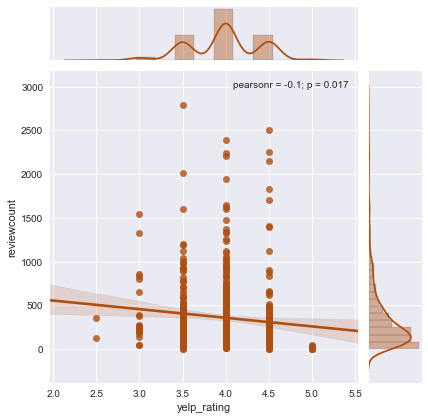

In [228]:
sns.jointplot(x='yelp_rating', y='reviewcount', data=df_nyt_yelp, color=sns.xkcd_rgb['burnt sienna'], kind='reg');

No relationship, which is reassuring that # of Yelp reviews probably does not affect rating.

### 2.2 Closures & Yelp ratings

Are closed businesses (i.e. went out of business) more likely to have low Yelp ratings?

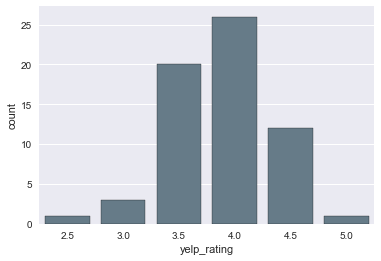

In [227]:
df = df_nyt_yelp[df_nyt_yelp['isclosed']==True]
sns.countplot('yelp_rating', data=df, color=sns.xkcd_rgb['blue grey']);

Surprisingly, there is a fairly normal distribution of ratings with many having a 4.0 average. Several even have Yelp averages > 4.5, and one with a 5.0. There are certainly other factors involved in why the businesses closed.

# 3. NYT - looking further into "Critic's Pick"

Previously, we've looked at NYT stars and compared this rating system w/ Yelp ratings. Now we take a closer look at "NYT Critic's Pick". 

### 3.1 Exploring the meaning behind "NYT Critic's Pick"

Following up from our last graph, for comparison the number of restaurants awarded with NYT "Critic's Pick" is below:

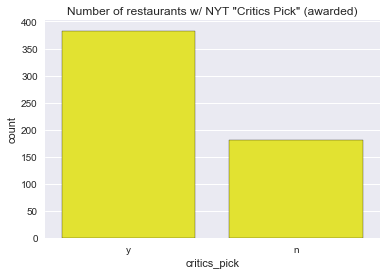

In [78]:
sns.countplot(x='critics_pick', data=df_nyt_yelp, color=sns.xkcd_rgb['yellow']).set_title('Number of restaurants w/ NYT "Critics Pick" (awarded)');

383 restaurants were awarded the "NYT Critic's Pick" label ('y'), which is appx twice the number that have not. Restaurants that weren't given the "NYT Critic's Pick" label could have already been awarded stars. It's possible, however, that the restaurant simply had a write-up or news piece about it. Additionally, it may not have been deemed sufficiently notable to receive  "Critic's Pick".

### 3.2 "NYT Critic's Pick" vs. "NYT stars"

To examine the above results more carefully, we can determine whether restaurants were not awarded "NYT Critic's Pick" due to the fact that they were already awarded stars. We perform a comparison between whether  "NYT Critic's Pick" restaurants tend to have stars (or not). 

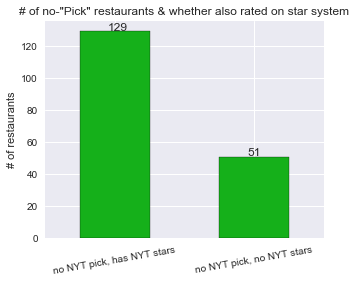

In [167]:
# Generate categories
df = df_nyt_yelp[df_nyt_yelp['critics_pick']=='n']
nopick_stars = sum(df['nyt_stars'].isnull())
nopick_nostars = len(df)-nopick_stars

# Plot histogram
labels = ['no NYT pick, has NYT stars', 'no NYT pick, no NYT stars']
a = pd.DataFrame({'# of reviews per restaurant': labels,
                  'review systems for restaurant': [nopick_stars, nopick_nostars]})
ax = a.plot(kind='bar', figsize=(5,4), color = sns.xkcd_rgb['green'])
ax.set_xticklabels(labels, rotation=10);
plt.ylabel('# of restaurants')
plt.title('# of no-"Pick" restaurants & whether also rated on star system');
ax.legend_.remove()

for p, label in zip(ax.patches, [nopick_stars, nopick_nostars]):
    ax.annotate(label, (p.get_x()+0.2, p.get_height()+0.2))

There were 51 restaurants that were both not deemed noteworthy and did not have stars. There are more than twice the number of restaurants that had NYT stars, despite not receiving "NYT Critic's Pick". This indicates that:
- We should not rely solely on NYT stars or "NYT Critic's Pick" to label "good"/"bad"-rated restaurants (under the NYT review system).
- There are probably ~ 51 restaurants that are "neither good nor bad", as they did not receive a poor rating under NYT's star system (since they were never evaluated under this system) but also were not deemed sufficiently noteworthy to receive a "Critic's Pick" label.

### Restaurant closures

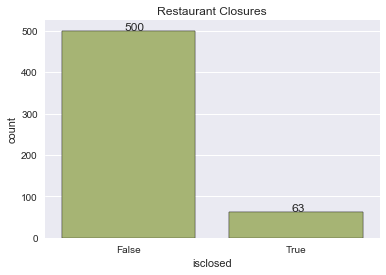

In [136]:
sns.countplot(x='isclosed', data=df_nyt_yelp, color=sns.xkcd_rgb['light olive']).set_title('Restaurant Closures');

num_open = len(df_nyt_yelp)-sum(df_nyt_yelp['isclosed'])
num_closed = sum(df_nyt_yelp['isclosed'])

ax = sns.countplot(x='isclosed', data=df_nyt_yelp, color=sns.xkcd_rgb['light olive']);
for p, label in zip(ax.patches, [num_open, num_closed]):
    ax.annotate(label, (p.get_x()+0.375, p.get_height()+0.2))

### 1.3 When were ratings published?

Convert `nyt_review_time` column values to datetime objects.

In [ ]:
from dateutil import parser

df_nyt_yelp['nyt_review_time'] = [parser.parse(t) for t in df_nyt_yelp['nyt_review_time']]

Number of NYT restaurant reviews published online seems fairly consistent after 2011 - this is reassuring, since we begin our Yelp and NYT data collection for restaurants reviewed in NYT beginning in 2012. Since we are still mid-way through 2018, difficult to say what 2018 will look like by the end of year.

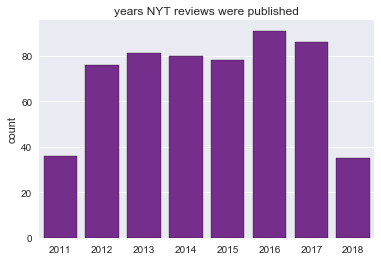

In [162]:
years = [t.year for t in df_nyt_yelp['nyt_review_time']]
ax = sns.countplot(years, color=sns.xkcd_rgb['purple']).set_title('years NYT reviews were published');

In [163]:
df_nyt_yelp.head()

,nyt_name,nyt_review_time,yelp_id,isclosed,yelp_rating,reviewcount,yelp_price,yelp_url,yelp_name,critics_pick,nyt_stars,yelp_reviews
0,Davelle,2018-06-07,PwrYnl3j3YCGzILX_5UHpw,False,4.0,47.0,2,https://www.yelp.com/biz/davelle-new-york-2,Davelle,y,NaN,NaN
1,Lahi,2018-05-31,kDqW1eeZEDTitXerwzwCzw,False,4.5,4.0,1,https://www.yelp.com/biz/lahi-queens,LAHI,n,NaN,NaN
2,Don Angie,2018-05-29,h37t9rA06Sr4EetJjKrfzw,False,4.5,126.0,3,https://www.yelp.com/biz/don-angie-new-york,Don Angie,y,2,NaN
3,Rangoon Spoon,2018-05-24,chdmH_y3YReZgIlNzj8djQ,False,3.5,55.0,2,https://www.yelp.com/biz/rangoon-spoon-brooklyn,Rangoon Spoon,n,1,NaN
4,Wokuni,2018-05-22,D6ZEcG1FCZ18nekMWrhgMg,False,4.0,60.0,3,https://www.yelp.com/biz/wokuni-new-york,Wokuni,y,NaN,NaN
